In [ ]:
!pip install kagglehub

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
dataset_path = kagglehub.dataset_download(
    "birdy654/cifake-real-and-ai-generated-synthetic-images"
)

train_dir = os.path.join(dataset_path, "train")
test_dir  = os.path.join(dataset_path, "test")

print("Dataset Path:", dataset_path)
print("Classes:", os.listdir(train_dir))

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset Path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']


# Phase 1

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = full_train_dataset.classes
print("Class Names:", class_names)

Class Names: ['FAKE', 'REAL']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Using Device: cpu


In [ ]:
def evaluate(model, loader):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return loss_total/len(loader), correct/total


def train_model(model, epochs=8):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch+1}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    print("Training Complete")

train_model(model)

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# 🔥 Enable gradients for Grad-CAM
for param in model.parameters():
    param.requires_grad = True

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from PIL import Image
import random

In [ ]:
# ─── Modern Grad-CAM class with full_backward_hook (safer) ────────────────

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        # Use full_backward_hook (more reliable in newer PyTorch)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target_class=None):
        self.model.eval()
        logit = self.model(x)

        if target_class is None:
            target_class = logit.argmax(dim=1).item()

        score = logit[0, target_class]
        self.model.zero_grad()
        score.backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not captured – check hooks")

        grads = self.gradients[0]           # shape: C,H,W
        acts  = self.activations[0]         # shape: C,H,W

        weights = grads.mean(dim=(1,2), keepdim=True)   # Global Average Pool → C,1,1
        cam = (weights * acts).sum(dim=0).relu()        # H,W
        cam = cam / (cam.max() + 1e-8)
        return cam


# ─── Fixed visualization function ─────────────────────────────────────────
def get_four_samples(test_dir):
    real_path = os.path.join(test_dir, "REAL")
    fake_path = os.path.join(test_dir, "FAKE")

    real_imgs = [f for f in os.listdir(real_path)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]
    fake_imgs = [f for f in os.listdir(fake_path)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]

    if len(real_imgs) < 2 or len(fake_imgs) < 2:
        print("Not enough images found in test/REAL or test/FAKE")
        print(f"REAL count: {len(real_imgs)}, FAKE count: {len(fake_imgs)}")
        return []

    # First two REAL (sorted for reproducibility)
    real_sel = sorted(real_imgs)[:2]
    # Two random FAKE (for variety)
    fake_sel = random.sample(fake_imgs, min(2, len(fake_imgs)))

    samples = []
    for fn in real_sel:
        samples.append((os.path.join(real_path, fn), "REAL"))
    for fn in fake_sel:
        samples.append((os.path.join(fake_path, fn), "FAKE"))

    return samples
def show_gradcam_four_images():
    samples = get_four_samples(test_dir)
    if not samples:
        return

    print("\nSelected images for Grad-CAM visualization:")
    for p, c in samples:
        print(f"  • {os.path.basename(p):<20}  (True: {c})")

    # Ensure gradients are enabled
    for param in model.parameters():
        param.requires_grad = True

    model.eval()

    target_layer = model.layer4[-1].conv2
    gradcam = GradCAM(model, target_layer)

    fig, axes = plt.subplots(4, 3, figsize=(12, 14))
    fig.suptitle("Grad-CAM Explanations – TRUE vs PREDICTED", fontsize=16, y=0.98)

    for i, (img_path, true_label) in enumerate(samples):

        if not os.path.isfile(img_path):
            print(f"Missing file: {img_path}")
            continue

        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)

        # Get prediction (NO torch.no_grad here!)
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        # Convert numeric prediction to label name
        pred_label = class_names[pred_class]

        # Generate Grad-CAM using predicted class
        cam = gradcam(input_tensor, target_class=pred_class)

        cam_np = cam.detach().cpu().numpy()
        cam_np = np.maximum(cam_np, 0)
        cam_np = cam_np / (cam_np.max() + 1e-8)

        # Resize CAM
        cam_resized = np.array(
            Image.fromarray(cam_np).resize((224, 224), Image.BILINEAR)
        )

        cmap = plt.get_cmap('jet')
        heatmap = cmap(cam_resized)[:, :, :3]

        img_resized = np.array(img.resize((224, 224))) / 255.0
        overlay = (0.40 * heatmap + 0.60 * img_resized).clip(0, 1)

        # Plot Original
        axes[i,0].imshow(img_resized)
        axes[i,0].set_title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        axes[i,0].axis('off')

        # Plot Heatmap
        axes[i,1].imshow(heatmap)
        axes[i,1].set_title("Grad-CAM Heatmap")
        axes[i,1].axis('off')

        # Plot Overlay
        axes[i,2].imshow(overlay)
        axes[i,2].set_title("Overlay")
        axes[i,2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Remove hooks after visualization
    gradcam = None


Selected images for Grad-CAM visualization:
  • 0000 (10).jpg         (True: REAL)
  • 0000 (2).jpg          (True: REAL)
  • 855 (7).jpg           (True: FAKE)
  • 316.jpg               (True: FAKE)


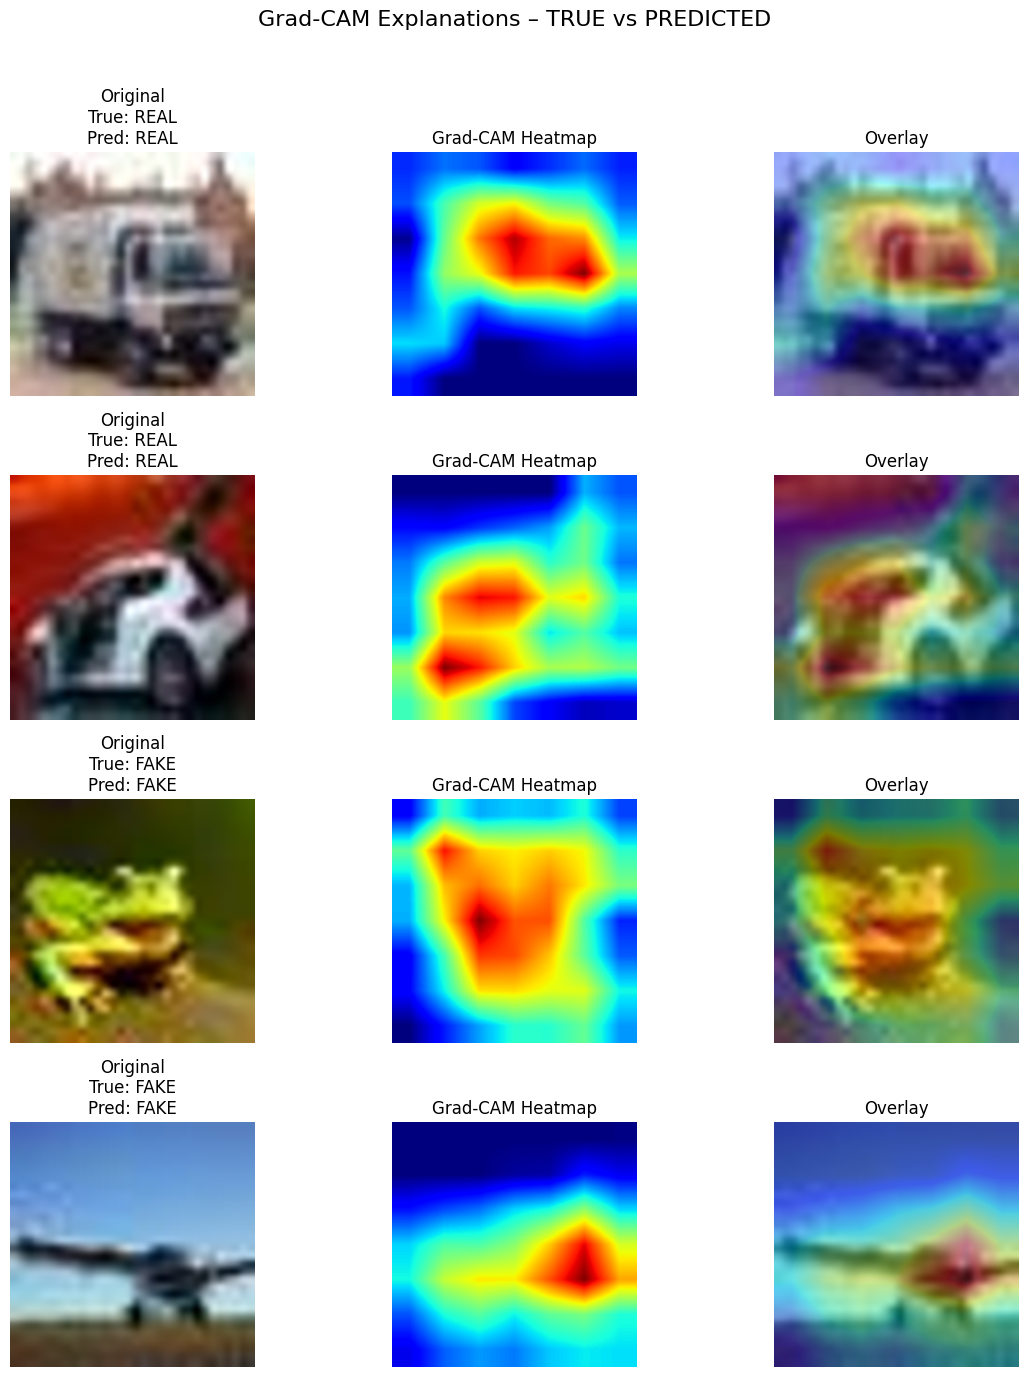

In [ ]:
model.eval()
show_gradcam_four_images()

# Phase 2

In [31]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate ResNet18
model = models.resnet18(pretrained=False)

# Replace final layer (same as training)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# Select high-confidence FAKE images
def get_high_conf_fake(model, loader, threshold=0.95, max_samples=3):
    model.eval()
    selected = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            for i in range(len(labels)):
                if labels[i] == 0:  # FAKE class = 0, REAL class = 1
                    conf = probs[i,0].item()
                    if conf > threshold:
                        print(f"Selected sample with FAKE confidence: {conf:.4f}")
                        selected.append((inputs[i].cpu(), conf))
                        if len(selected) >= max_samples:
                            return selected
    return selected

In [33]:
samples = get_high_conf_fake(model, test_loader, max_samples=5)

Selected sample with FAKE confidence: 0.9808
Selected sample with FAKE confidence: 0.9923
Selected sample with FAKE confidence: 0.9817
Selected sample with FAKE confidence: 0.9952
Selected sample with FAKE confidence: 0.9891


In [34]:
def get_confidence(img_tensor):
    model.eval()
    with torch.no_grad():
        out = model(img_tensor.to(device))
        prob = torch.softmax(out, dim=1)
    return prob.cpu().numpy()

### Evasion using Gaussian noise

In [28]:
# Gaussian noise (easy baseline)

def add_gaussian_noise(img, epsilon):
    noise = torch.randn_like(img) * epsilon
    return torch.clamp(img + noise, 0, 1)

In [36]:
def evasion_experiment_noise(img):
    steps = []
    current = img.clone()

    for eps in [0.01, 0.02, 0.05, 0.075, 0.1, 0.5]:
        modified = add_gaussian_noise(current, eps)
        prob = get_confidence(modified)[0]

        steps.append((modified, prob))

        if prob[1] > prob[0]:  # predicted REAL
            break

    return steps

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progression_noise(original_img, steps):
    orig = original_img.squeeze().permute(1, 2, 0).clamp(0, 1)

    num_images = 1 + len(steps)
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    axes = np.atleast_1d(axes)
    org_prob = get_confidence(original_img.unsqueeze(0))[0]

    # Plot original image first
    axes[0].imshow(orig)
    axes[0].set_title(f"Original:\nReal={org_prob[1]:.4f}\nFake={org_prob[0]:.4f}")
    axes[0].axis('off')

    # Plot all steps
    for i, (img, prob) in enumerate(steps):
        img_to_plot = img.squeeze().permute(1, 2, 0).clamp(0, 1)
        axes[i+1].imshow(img_to_plot)
        axes[i+1].set_title(f"Real:{prob[1]:.2f}\nFake:{prob[0]:.2f}")
        axes[i+1].axis('off')

    plt.show()

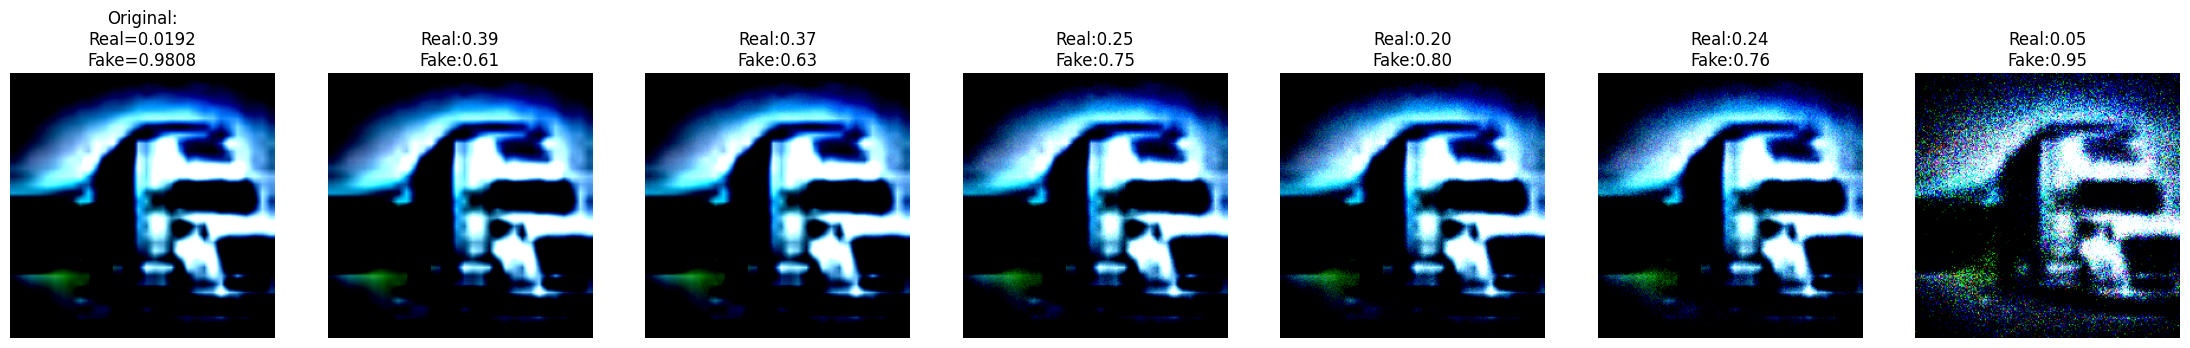

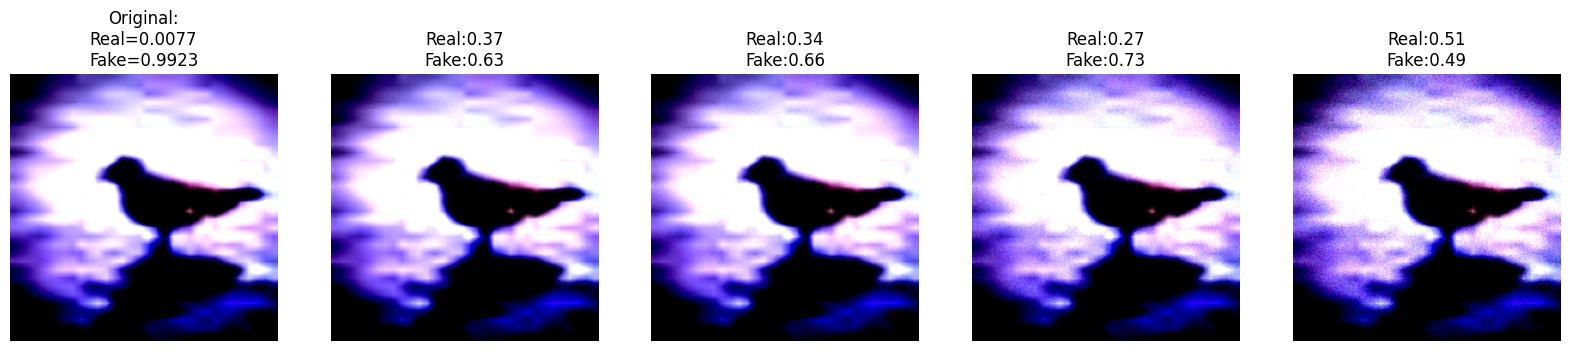

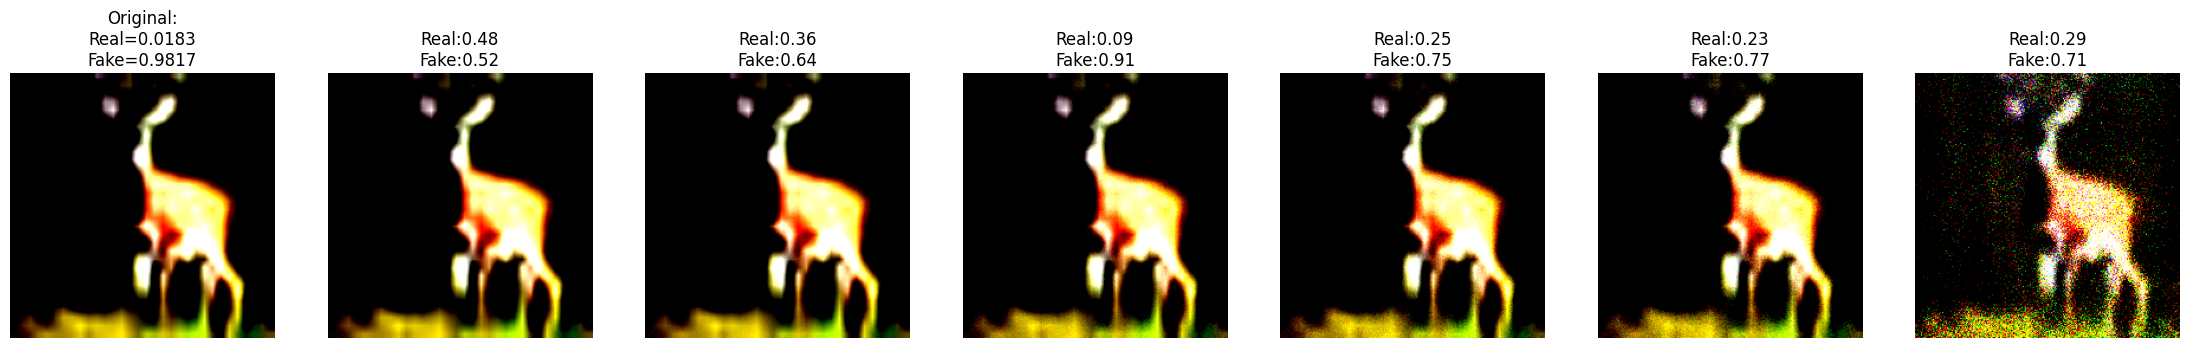

In [38]:
images_for_gaussian_noise_evasion = [s[0] for s in samples[:3]]  # pick few images

for img in images_for_gaussian_noise_evasion:
    img_batched = img.unsqueeze(0)  # add batch dimension
    steps = evasion_experiment_noise(img_batched)
    plot_progression_noise(img, steps)

In [40]:
import numpy as np
import torch.fft as fft
import matplotlib.pyplot as plt

def compute_spectrum(img):
    if img.dim() == 4:
        img = img[0]
    gray = img.mean(0)
    freq = torch.log(torch.abs(fft.fftshift(fft.fft2(gray))) + 1)
    return freq.cpu()

def plot_frequency_progression(original, steps):
    org_prob = get_confidence(original.unsqueeze(0))[0]

    spectra = [compute_spectrum(original)]
    titles = [f"Original \nReal:{org_prob[1]:.4f}\nFake:{org_prob[0]:.4f}"]

    for i, (img, prob) in enumerate(steps):
        spectra.append(compute_spectrum(img))
        titles.append(f"Step {i+1}\nReal:{prob[1]:.2f}\nFake:{prob[0]:.2f}")

    n = len(spectra)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    axes = np.atleast_1d(axes)

    for ax, spec, title in zip(axes, spectra, titles):
        ax.imshow(spec, cmap="plasma")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

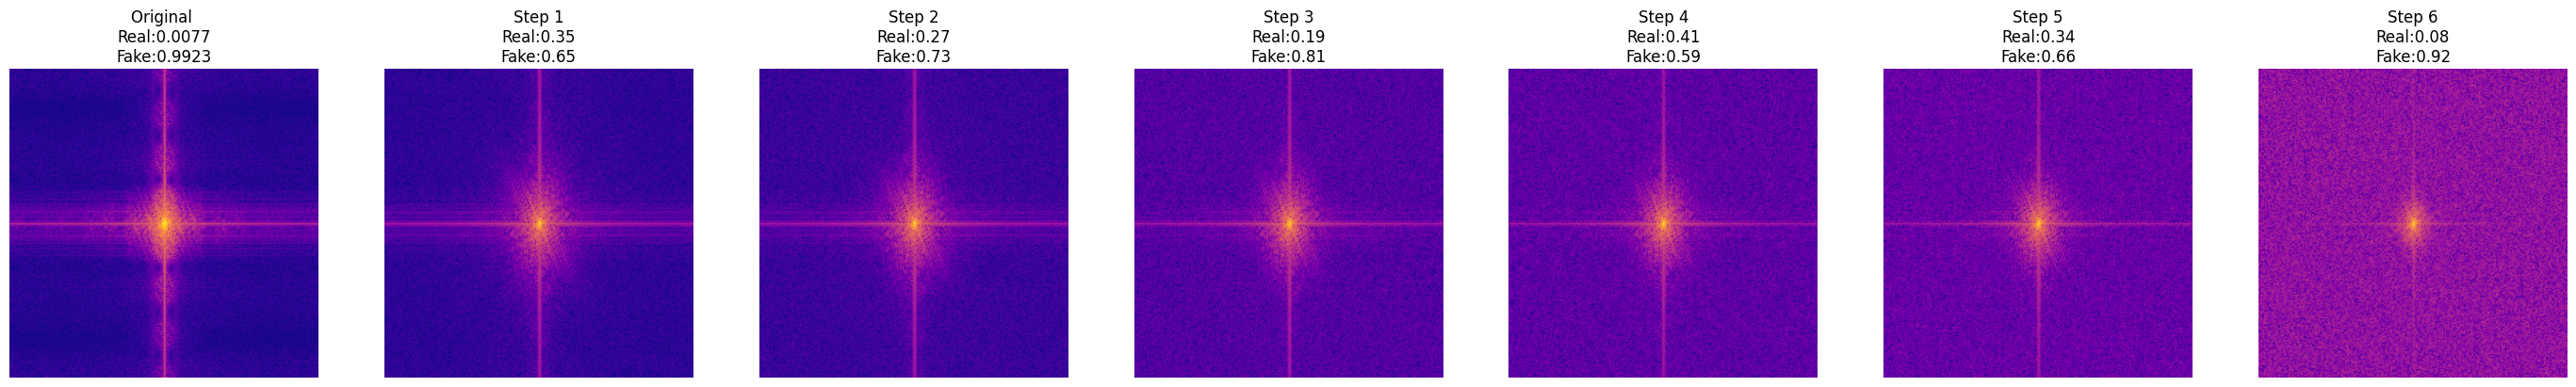

In [41]:
orig = samples[1][0]
steps = evasion_experiment_noise(orig.unsqueeze(0))

plot_frequency_progression(orig, steps)

### Evasion using Blur

In [42]:
# Blur (suppresses artifacts) - Since Synthetic images have high frequency artifacts

import torchvision.transforms.functional as TF

def blur_image(img, k=5):
    return TF.gaussian_blur(img, kernel_size=k)

In [43]:
def evasion_experiment_blur(img):
    steps = []
    current = img.clone()

    for k in [3, 5, 7, 11, 15, 17]:
        modified = blur_image(current, k).clamp(0, 1)
        prob = get_confidence(modified)[0]

        steps.append((modified, prob))

        if prob[1] > prob[0]:  # predicted REAL
            break

    return steps

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progression_blur(original_img, steps):
    orig = original_img.squeeze().permute(1, 2, 0).clamp(0, 1)

    num_images = 1 + len(steps)
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    axes = np.atleast_1d(axes)
    org_prob = get_confidence(original_img.unsqueeze(0))[0]

    # Plot original image first
    axes[0].imshow(orig)
    axes[0].set_title(f"Original:\nReal={org_prob[1]:.4f}\nFake={org_prob[0]:.4f}")
    axes[0].axis('off')

    # Plot all steps
    for i, (img, prob) in enumerate(steps):
        img_to_plot = img.squeeze().permute(1, 2, 0).clamp(0, 1)
        axes[i+1].imshow(img_to_plot)
        axes[i+1].set_title(f"Real:{prob[1]:.2f}\nFake:{prob[0]:.2f}")
        axes[i+1].axis('off')

    plt.show()

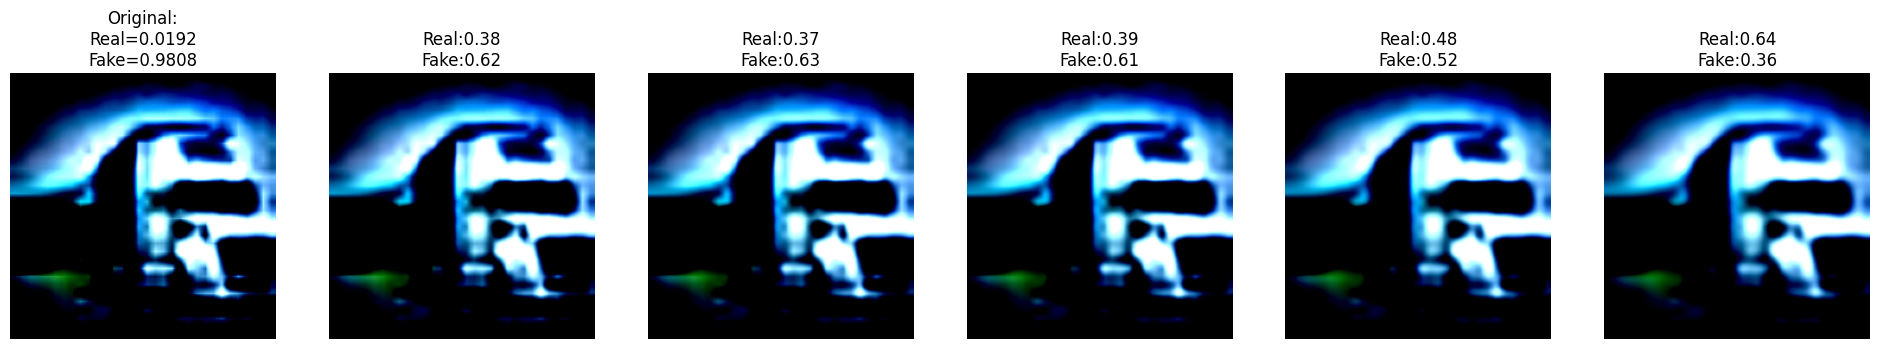

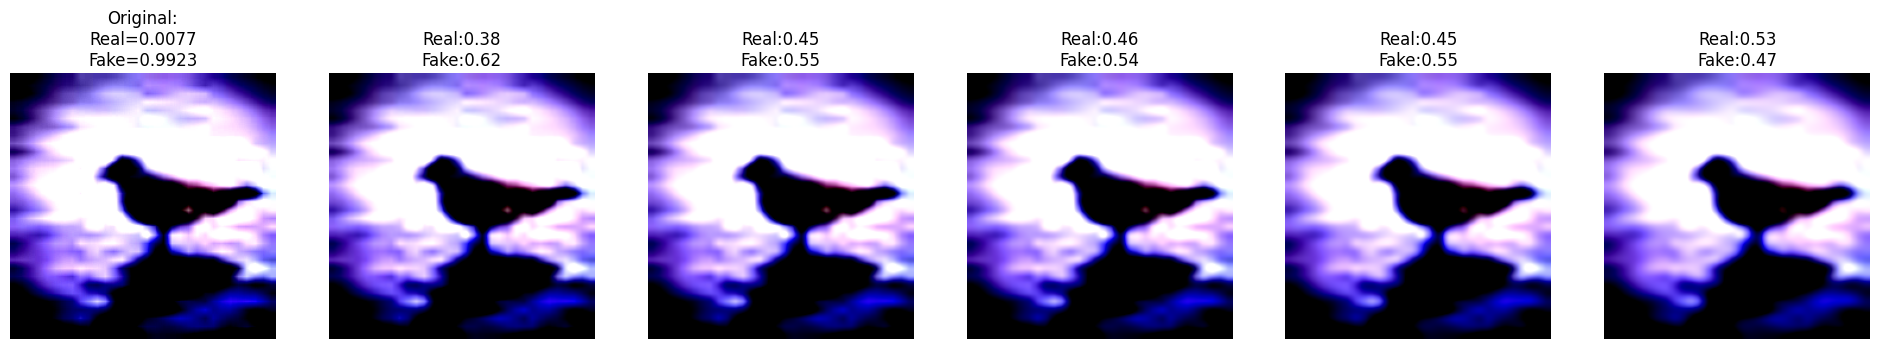

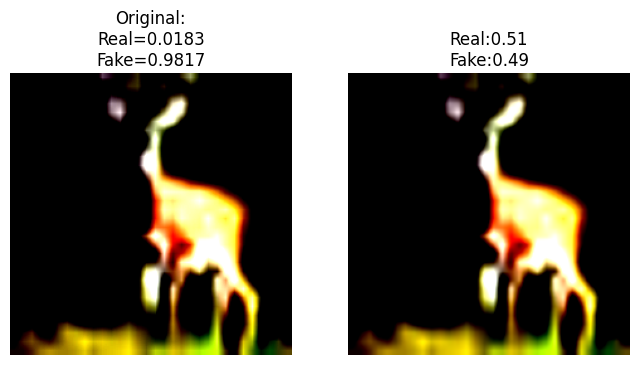

In [45]:
images_for_blur_evasion = [s[0] for s in samples[:3]]  # pick few images

for img in images_for_blur_evasion:
    img_batched = img.unsqueeze(0)  # add batch dimension
    steps = evasion_experiment_blur(img_batched)
    plot_progression_blur(img, steps)

In [46]:
import numpy as np
import torch.fft as fft
import matplotlib.pyplot as plt

def compute_spectrum(img):
    if img.dim() == 4:
        img = img[0]
    gray = img.mean(0)
    freq = torch.log(torch.abs(fft.fftshift(fft.fft2(gray))) + 1)
    return freq.cpu()

def plot_frequency_progression(original, steps):
    org_prob = get_confidence(original.unsqueeze(0))[0]

    spectra = [compute_spectrum(original)]
    titles = [f"Original \nReal:{org_prob[1]:.4f}\nFake:{org_prob[0]:.4f}"]

    for i, (img, prob) in enumerate(steps):
        spectra.append(compute_spectrum(img))
        titles.append(f"Step {i+1}\nReal:{prob[1]:.2f}\nFake:{prob[0]:.2f}")

    n = len(spectra)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    axes = np.atleast_1d(axes)

    for ax, spec, title in zip(axes, spectra, titles):
        ax.imshow(spec, cmap="inferno")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

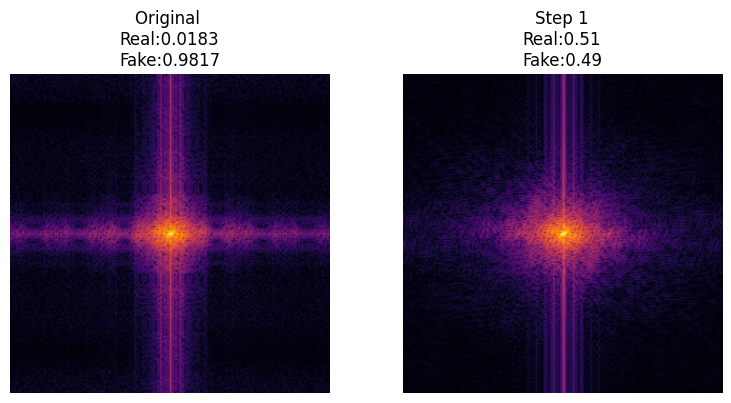

In [47]:
orig = samples[2][0]
steps = evasion_experiment_blur(orig.unsqueeze(0))

plot_frequency_progression(orig, steps)

### Evasion using FGSM (Fast Gradient Sign Method)

In [48]:
# FGSM adversarial attack - Uses gradients to perturb pixels optimally.

def fgsm_attack(image, epsilon):
    image = image.clone().detach().to(device)
    image.requires_grad = True

    output = model(image)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([1]).to(device))  # target FAKE

    model.zero_grad()
    loss.backward()

    perturbed = image + epsilon * image.grad.sign()
    return torch.clamp(perturbed, 0, 1).detach()

In [49]:
def evasion_experiment_fgsm(img):
    steps = []
    current = img.clone()

    for eps in [0.005, 0.01, 0.05, 0.1, 0.5]:
        modified = fgsm_attack(current, eps)
        prob = get_confidence(modified)[0]

        steps.append((modified, prob))

        if prob[1] > prob[0]:  # predicted REAL
            break

    return steps

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_progression_fgsm(original_img, steps):
    orig = original_img.squeeze().permute(1, 2, 0).clamp(0, 1)

    num_images = 1 + len(steps)
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    axes = np.atleast_1d(axes)
    org_prob = get_confidence(original_img.unsqueeze(0))[0]

    # Plot original image first
    axes[0].imshow(orig)
    axes[0].set_title(f"Original:\nReal={org_prob[1]:.4f}\nFake={org_prob[0]:.4f}")
    axes[0].axis('off')

    # Plot all steps
    for i, (img, prob) in enumerate(steps):
        img_to_plot = img.squeeze().permute(1, 2, 0).clamp(0, 1).cpu()
        axes[i+1].imshow(img_to_plot)
        axes[i+1].set_title(f"Real:{prob[1]:.2f}\nFake:{prob[0]:.2f}")
        axes[i+1].axis('off')

    plt.show()

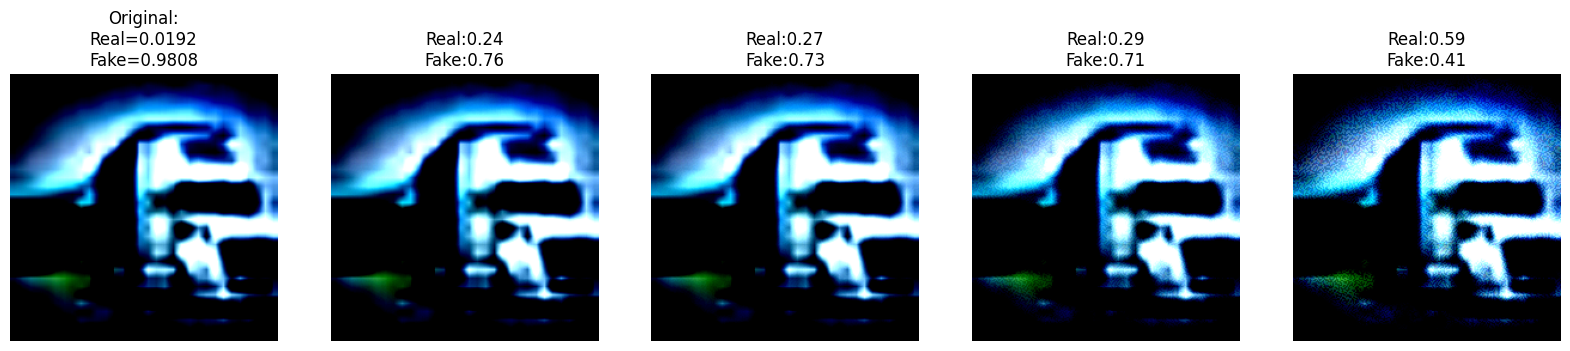

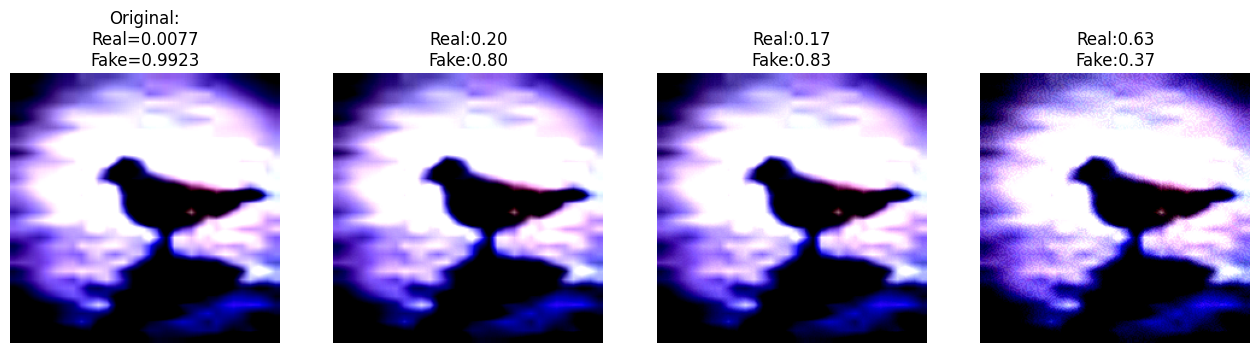

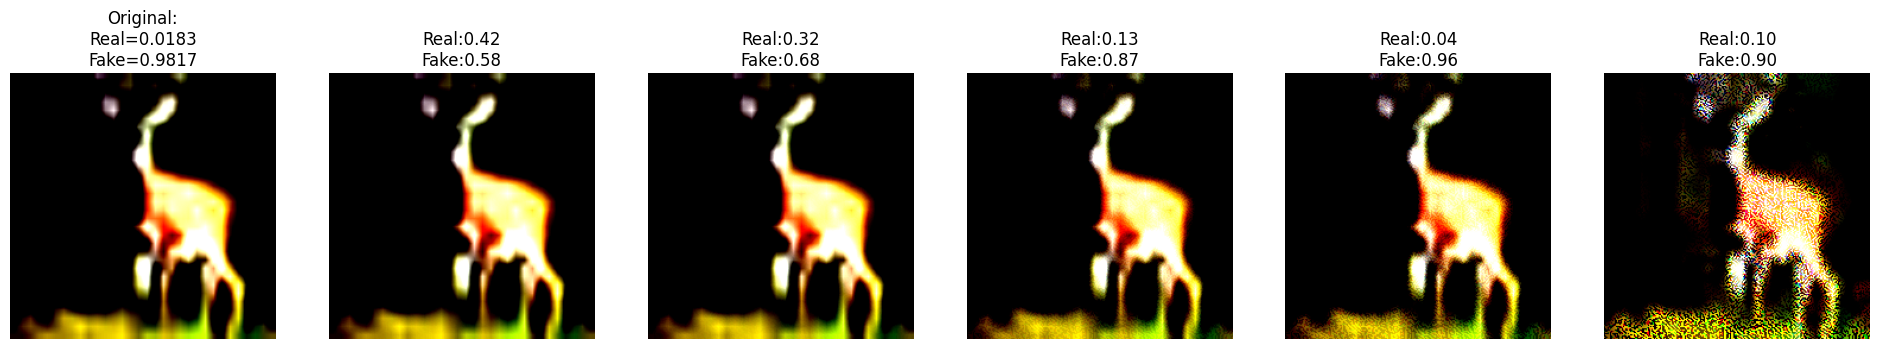

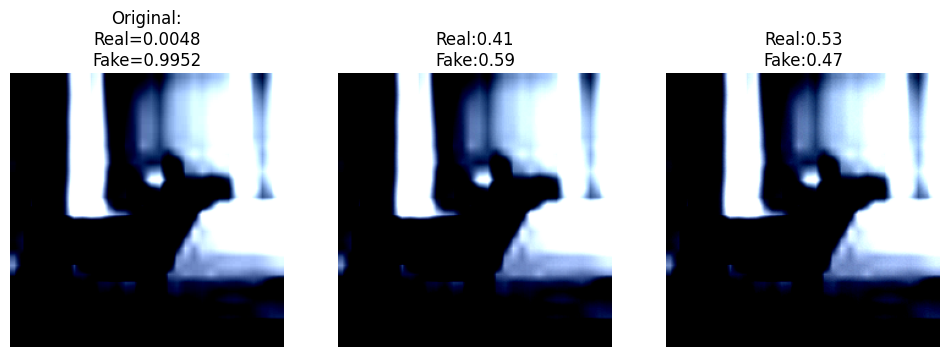

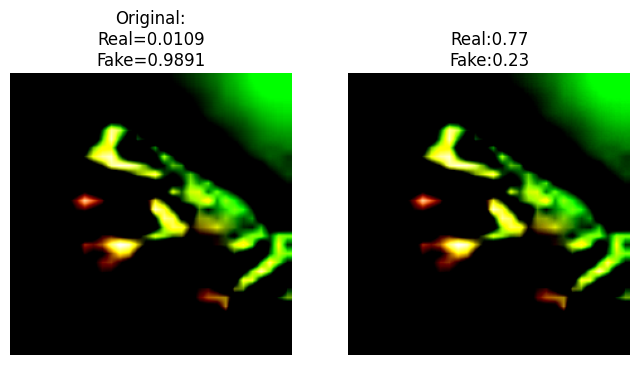

In [51]:
images_for_fgsm_evasion = [s[0] for s in samples]

for img in images_for_fgsm_evasion:
    img_batched = img.unsqueeze(0)  # add batch dimension for model
    steps = evasion_experiment_fgsm(img_batched)
    plot_progression_fgsm(img, steps)

In [52]:
import matplotlib.pyplot as plt

def plot_confidence_curve(steps, title="Confidence vs Perturbation"):
    real_probs = [prob[1] for _, prob in steps]
    fake_probs = [prob[0] for _, prob in steps]
    x = list(range(len(steps)))

    plt.figure(figsize=(6,4))
    plt.plot(x, real_probs, marker='o', label="Real confidence")
    plt.plot(x, fake_probs, marker='o', label="Fake confidence")
    plt.xlabel("Step")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend()
    plt.show()

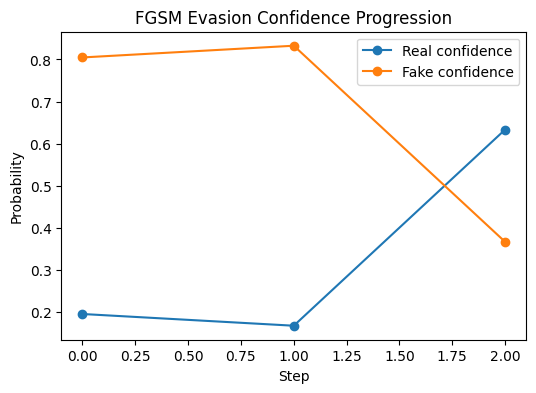

In [54]:
orig = samples[1][0]
steps = evasion_experiment_fgsm(orig.unsqueeze(0))

plot_confidence_curve(steps, title="FGSM Evasion Confidence Progression")

# Phase 3

In [4]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

robust_model = models.resnet18(weights=None)  # modern torchvision style
robust_model.fc = nn.Linear(robust_model.fc.in_features, 2)

# Load baseline weights (DO NOT overwrite best_model.pth)
robust_model.load_state_dict(torch.load("best_model.pth", map_location=device))

robust_model = robust_model.to(device)

optimizer = optim.Adam(robust_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("Robust model initialized from baseline.")

Robust model initialized from baseline.


In [5]:
import torchvision.transforms.functional as TF

def blur_batch(images, kernel_size=5):

    blurred = []

    for i in range(images.size(0)):
        img = TF.gaussian_blur(images[i], kernel_size=kernel_size)
        blurred.append(img)

    return torch.stack(blurred).to(device)

In [6]:
def generate_fgsm_batch(model, images, labels, epsilon=0.01):

    model.eval()   # important for stable gradients

    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # FGSM perturbation
    perturbed_images = images + epsilon * images.grad.sign()

    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images.detach()

In [7]:
def add_gaussian_noise(images, epsilon=0.02):
    noise = torch.randn_like(images) * epsilon
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)

In [12]:
robust_model.train()

print("Starting Multi-Attack Robust Training...")

num_epochs = 3

for epoch in range(num_epochs):

    total_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        # -----------------------------
        # Generate adversarial variants
        # -----------------------------

        noisy_imgs = add_gaussian_noise(images, epsilon=0.1)
        blurred_imgs = blur_batch(images, kernel_size=15)
        fgsm_imgs = generate_fgsm_batch(robust_model, images, labels, epsilon=0.075)

        # Switch back to train mode
        robust_model.train()

        # -----------------------------
        # Combine clean + all attacks
        # -----------------------------

        combined_images = torch.cat([
            images,
            noisy_imgs,
            blurred_imgs,
            fgsm_imgs
        ], dim=0)

        combined_labels = torch.cat([
            labels,
            labels,
            labels,
            labels
        ], dim=0)

        # -----------------------------
        # Train step
        # -----------------------------

        optimizer.zero_grad()

        outputs = robust_model(combined_images)
        loss = criterion(outputs, combined_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

print("Robust training complete.")

Starting Multi-Attack Robust Training...
Epoch 1/3 - Avg Loss: 0.0381
Epoch 2/3 - Avg Loss: 0.0271
Epoch 3/3 - Avg Loss: 0.0222
Robust training complete.


In [13]:
torch.save(robust_model.state_dict(), "robust_model_multidefense.pth")

print("Robust model saved as robust_model_multidefense.pth")

Robust model saved as robust_model_multidefense.pth


In [14]:
def evaluate_confidence(model, img_tensor):
    model.eval()

    with torch.no_grad():
        outputs = model(img_tensor.to(device))
        probs = torch.softmax(outputs, dim=1)

    return probs.cpu().numpy()[0]

In [22]:
print("\nEvaluating robustness against all three attacks...\n")
images = [s[0] for s in samples]

for i, img in enumerate(images):

    img_batch = img.unsqueeze(0)

    # Clean
    base_clean = evaluate_confidence(model, img_batch)
    robust_clean = evaluate_confidence(robust_model, img_batch)

    # Gaussian Noise
    noisy = add_gaussian_noise(img_batch, 0.075)
    base_noise = evaluate_confidence(model, noisy)
    robust_noise = evaluate_confidence(robust_model, noisy)

    # Blur
    blurred = blur_batch(img_batch, 11)
    base_blur = evaluate_confidence(model, blurred)
    robust_blur = evaluate_confidence(robust_model, blurred)

    # FGSM
    adv = fgsm_attack(img_batch, epsilon=0.05)
    base_adv = evaluate_confidence(model, adv)
    robust_adv = evaluate_confidence(robust_model, adv)

    print(f"\nSample {i+1}")
    print("Clean:")
    print("  Base   ->", base_clean)
    print("  Robust ->", robust_clean)

    print("Gaussian Noise:")
    print("  Base   ->", base_noise)
    print("  Robust ->", robust_noise)

    print("Blur:")
    print("  Base   ->", base_blur)
    print("  Robust ->", robust_blur)

    print("FGSM:")
    print("  Base   ->", base_adv)
    print("  Robust ->", robust_adv)

    print("-"*60)


Evaluating robustness against all three attacks...


Sample 1
Clean:
  Base   -> [0.00363577 0.9963643 ]
  Robust -> [2.4180489e-08 1.0000000e+00]
Gaussian Noise:
  Base   -> [0.07651205 0.92348796]
  Robust -> [7.346143e-07 9.999993e-01]
Blur:
  Base   -> [0.00190998 0.99808997]
  Robust -> [1.7689326e-06 9.9999821e-01]
FGSM:
  Base   -> [0.07056548 0.9294346 ]
  Robust -> [1.0800435e-06 9.9999893e-01]
------------------------------------------------------------

Sample 2
Clean:
  Base   -> [0.00161908 0.9983809 ]
  Robust -> [2.0611154e-08 1.0000000e+00]
Gaussian Noise:
  Base   -> [0.01679056 0.98320943]
  Robust -> [2.5113317e-04 9.9974889e-01]
Blur:
  Base   -> [0.04384559 0.95615435]
  Robust -> [7.068841e-07 9.999993e-01]
FGSM:
  Base   -> [0.01613148 0.98386854]
  Robust -> [2.1862696e-04 9.9978143e-01]
------------------------------------------------------------

Sample 3
Clean:
  Base   -> [0.03142025 0.96857977]
  Robust -> [6.6391825e-05 9.9993360e-01]
Gaussian Noise:
  Ba